# Generation City Names Based on Country

Architecture based on tutorial from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

## Imports

In [103]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset prep

In [104]:
# Vocabulary
all_letters = string.printable
n_letters = len(all_letters) + 1 

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

def findFiles(path): return glob.glob(path)

In [105]:
data_dir = os.path.join(os.pardir, 'data', 'worldcities.csv')
raw_df = pd.read_csv(data_dir)[['city_ascii', 'country']]

# Listing all cities for each country
grouped_cities = raw_df.groupby('country')['city_ascii'].apply(list).reset_index(name='cities')

# Removing all countries where number of cities < 100
city_count = raw_df.groupby('country').count().reset_index()
countries_to_keep = city_count[city_count.city_ascii > 100].country
grouped_cities = grouped_cities[grouped_cities.country.isin(countries_to_keep)]


# Preparing country city dict and label list
all_countries = grouped_cities['country'].unique().tolist()
city_dict = {country: city_lst for country, city_lst in grouped_cities.to_numpy()}
n_categories = len(all_countries)
print(n_categories)
print(all_countries)

50
['Algeria', 'Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Czechia', 'Dominican Republic', 'Egypt', 'Finland', 'France', 'Germany', 'Greece', 'Guatemala', 'Hungary', 'India', 'Indonesia', 'Iran', 'Italy', 'Japan', 'Kazakhstan', 'Mexico', 'Morocco', 'Netherlands', 'Norway', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia', 'South Africa', 'Spain', 'Switzerland', 'Syria', 'Thailand', 'Turkey', 'Uganda', 'Ukraine', 'United Kingdom', 'United States']


## City Generator

In [106]:
class CityNameRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CityNameRNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


## Training Functions

Functions to get a random training pair from the training data 

In [107]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_countries)
    line = randomChoice(city_dict[category])
    return category, line

# Testing
randomTrainingPair()

('Japan', 'Nakagawa')

Functions to encode training examples 

In [108]:
# One-hot vector for category
def categoryTensor(category):
    li = all_countries.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [109]:
## Testing 

categoryTensor('Algeria')

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [110]:
x = randomTrainingPair()
inputTensor(x[1])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [111]:
targetTensor(x[1])

tensor([ 14,  21,  16,  27,  10,  13,  14, 100])

Training function combining all above functions

In [112]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    #print(category, line)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# Testing 

randomTrainingExample()

(tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Other helpers

In [113]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## Training the network

In [114]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(net, category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = net.initHidden()

    net.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = net(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in net.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [115]:
net = CityNameRNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters


start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(net, *randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 18s (5000 5%) 3.7015
0m 36s (10000 10%) 3.3725
0m 54s (15000 15%) 3.1831
1m 12s (20000 20%) 2.2289
1m 30s (25000 25%) 3.2534
1m 48s (30000 30%) 2.8919
2m 7s (35000 35%) 2.6901
2m 25s (40000 40%) 2.2955
2m 43s (45000 45%) 1.9619
3m 1s (50000 50%) 2.1922
3m 19s (55000 55%) 2.6699
3m 37s (60000 60%) 2.3243
3m 55s (65000 65%) 2.5394
4m 13s (70000 70%) 2.4785
4m 32s (75000 75%) 3.0369
4m 50s (80000 80%) 2.4935
5m 9s (85000 85%) 2.6581
5m 27s (90000 90%) 3.1073
5m 45s (95000 95%) 2.8341
6m 3s (100000 100%) 2.5273


## Plotting Loss

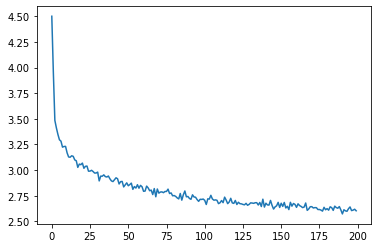

In [116]:
plt.figure()
plt.plot(all_losses)

## generating Text

In [119]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = net.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = net(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [120]:
samples('Germany', 'GER')

Gerten
Ellang
Renten


In [123]:
samples('Norway', 'MSR')

Manden
Sanden
Roste


In [124]:
samples('United Kingdom', 'WRE')

Worten
Ronten
Erten


In [125]:
samples('United States', 'WRE')

Wallen
Ronton
Ellen
